In [1]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import datetime
import time
from datetime import date
import statsmodels.api as sm
import scipy.stats
from scipy.stats import norm
import matplotlib.pyplot as plt


import openpyxl
from openpyxl import load_workbook

start = datetime.datetime (1950, 1, 1)
df1 = pd.read_excel('C:/Users/lavella/Quintet Private Bank/UK Sandbox DPT ICS - Documents/Sector Selection - Copy/Philip Odum/Philip Odum/ICI/Quintet US ICI mastersheet (new).xlsx','Summary').set_index('Date').resample('M').last()
df2 = pd.read_excel('C:/Users/lavella/Quintet Private Bank/UK Sandbox DPT ICS - Documents/Sector Selection - Copy/Philip Odum/Philip Odum/Inflation/Data/Conference Board - Leading Indicator.xlsx').set_index('Date').resample('M').last()
df3 = pd.read_excel('C:/Users/lavella/Quintet Private Bank/UK Sandbox DPT ICS - Documents/Sector Selection - Copy/Philip Odum/Philip Odum/Inflation/Data/Counterpoint Weekly - Recession Data.xlsx').set_index('Date')
df4 = pd.read_excel('C:/Users/lavella/Quintet Private Bank/UK Sandbox DPT ICS - Documents/Sector Selection - Copy/Philip Odum/Philip Odum/Inflation/Data/Counterpoint Weekly - OIS 3m18m.xlsx','Input - Bloomberg')
df5 = pd.read_excel('C:/Users/lavella/Quintet Private Bank/UK Sandbox DPT ICS - Documents/Sector Selection - Copy/Philip Odum/Philip Odum/Inflation/Data/Counterpoint Weekly - OIS 3m18m.xlsx','Output - 3X18')

df = pdr.DataReader(['DGS3MO','DGS2','DGS5','DGS10','DGS30','SAHMREALTIME','SAHMCURRENT','RECPROUSM156N','JHGDPBRINDX','USRECD','BAMLC0A4CBBB','GDPC1','GNP','USREC'], 'fred', start)

In [2]:
dx = pd.read_excel('C:/Users/lavella/Quintet Private Bank/UK Sandbox DPT ICS - Documents/Sector Selection - Copy/Philip Odum/Philip Odum/Inflation/Data/Counterpoint Weekly - OIS 3m18m.xlsx','Output - 3X18').iloc[:,1:3].set_index('Date2').dropna()
dy = pd.read_excel('C:/Users/lavella/Quintet Private Bank/UK Sandbox DPT ICS - Documents/Sector Selection - Copy/Philip Odum/Philip Odum/Inflation/Data/Counterpoint Weekly - OIS 3m18m.xlsx','Input - Refinitiv').set_index('Name')

### Recession ban

<AxesSubplot:xlabel='DATE'>

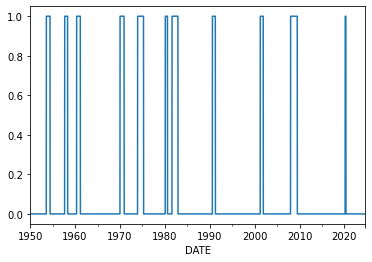

In [3]:
#See if you can incorporate NY Fed recession
df['USREC'] = df.iloc[:,-1].fillna(method='ffill')
df['USREC'].plot()

### Create 3M3X18

In [4]:
dz = pd.concat([dx,dy],axis=1)
dz = dz.iloc[:,0].fillna(dz.iloc[:,1]).to_frame().iloc[:-1]
dz.columns = ['3X18']

df = pd.concat([df,dz],axis=1)

dz

,3X18
1961-06-14,3.829396
1961-06-15,3.893479
1961-06-16,3.887552
1961-06-19,3.942042
1961-06-20,3.901772
...,...
2024-07-26,4.209500
2024-07-29,4.227700
2024-07-30,4.176400
2024-07-31,4.074800


In [5]:
df.iloc[:,14]

1950-01-01       NaN
1950-01-02       NaN
1950-01-03       NaN
1950-01-04       NaN
1950-01-05       NaN
               ...  
2024-08-01    3.9281
2024-08-02       NaN
2024-08-03       NaN
2024-08-04       NaN
2024-08-05       NaN
Freq: D, Name: 3X18, Length: 27246, dtype: float64

### Spreads

In [6]:
inv = df.resample('M').last()

inv['3m30y']=inv[inv.columns[4]].sub(inv[inv.columns[0]])
inv['2y30y']=inv[inv.columns[4]].sub(inv[inv.columns[1]])
inv['3m10y']=inv[inv.columns[3]].sub(inv[inv.columns[0]])
inv['2y10y']=inv[inv.columns[3]].sub(inv[inv.columns[1]])
inv['3m5y']=inv[inv.columns[2]].sub(inv[inv.columns[0]])
inv['2y5y']=inv[inv.columns[2]].sub(inv[inv.columns[1]])

inv['3m3x18'] = inv[inv.columns[14]].sub(inv[inv.columns[0]])

inv = inv[inv.columns[[13,15,16,17,18,19,20,21]]]
inv.tail(10)

,USREC,3m30y,2y30y,3m10y,2y10y,3m5y,2y5y,3m3x18
2023-11-30,0.0,-0.91,-0.19,-1.08,-0.36,-1.14,-0.42,-0.8584
2023-12-31,0.0,-1.37,-0.20,-1.52,-0.35,-1.56,-0.39,-1.3040
2024-01-31,0.0,-1.20,-0.05,-1.43,-0.28,-1.51,-0.36,-1.2919
2024-02-29,0.0,-1.07,-0.26,-1.20,-0.39,-1.19,-0.38,-0.8584
2024-03-31,0.0,-1.12,-0.25,-1.26,-0.39,-1.25,-0.38,-0.8443
2024-04-30,0.0,-0.67,-0.25,-0.77,-0.35,-0.74,-0.32,-0.4226
2024-05-31,0.0,-0.81,-0.24,-0.95,-0.38,-0.94,-0.37,-0.6081
2024-06-30,0.0,-0.97,-0.20,-1.12,-0.35,-1.15,-0.38,-0.8370
2024-07-31,0.0,-1.06,0.06,-1.32,-0.20,-1.44,-0.32,-1.3352
2024-08-31,0.0,-1.29,0.17,-1.57,-0.11,-1.73,-0.27,-1.4219


In [7]:
book = load_workbook('C:/Users/lavella/Quintet Private Bank/UK Sandbox DPT ICS - Documents/Sector Selection - Copy/Philip Odum/Philip Odum/Inflation/Data/Fixed Income - Recession Probabiliy (new).xlsx')
writer = pd.ExcelWriter('C:/Users/lavella/Quintet Private Bank/UK Sandbox DPT ICS - Documents/Sector Selection - Copy/Philip Odum/Philip Odum/Inflation/Data/Fixed Income - Recession Probabiliy (new).xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

inv.to_excel(writer, "Input - Inversion")

writer.save()

### Recession Frequency

In [8]:
recfreq = df['USRECD'].resample('Q').last().cumsum().iloc[-1]/len(df['USRECD'].resample('Q').last())
recfreq

0.12374581939799331

<AxesSubplot:>

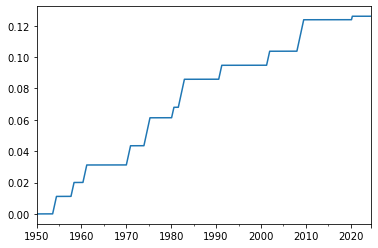

In [9]:
er = df['USRECD'].cumsum()/len(df['USRECD'])
er.plot()

### Spread US 2 year vs US 3 month (test)

In [10]:
#Importent, set lag
lag = 0

Optimization terminated successfully.
         Current function value: 0.272820
         Iterations 6


<AxesSubplot:>

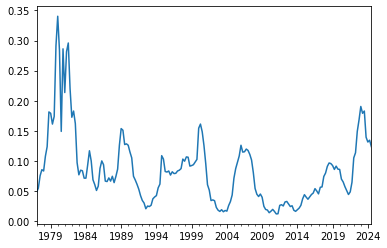

In [11]:
freq = 'Q'

fd = df.copy()
s1 = fd[fd.columns[4]]
s2 = fd[fd.columns[1]]
X = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).min()

X.loc[X>0] = 1
X.loc[X<0] = 0

y = fd['USREC'].resample(freq).min()

r1 = -24
r2 = 100
def createList(r1, r2):
    return list(range(r1, r2+1))
obs = createList(r1, r2)

corr = pd.DataFrame(columns=['Correlation'])
X11 = pd.DataFrame()
for i in obs:
    try:
        X11 = y.shift(i).corr(X)
    except:
        pass
    corr = corr.append({'Correlation': X11}, ignore_index=True)
#corr = abs(corr)

corr.index=range(r1,r2+1)


#Determine number of lags
#lag = corr.index.max()
#lag = 6


X = X.shift(lag).dropna()
X = sm.add_constant(X)

y = y.loc[X.dropna().index[0]:]

prob = sm.Probit(y,X).fit()

pred = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).min()
mu = 0
sigma = 1


dx = prob.params['const']+prob.params[0]*pred
dx = dx.loc[X.dropna().index[0]:]

X['rec'] = df['USRECD']

X['model'] = norm.cdf(dx,loc=mu,scale=sigma)
#X[['rec','model']].plot()
y3 = X['model']
y3.plot()

### For Combined measure

In [12]:
inv = inv.dropna().resample('Q').last()
inv

,USREC,3m30y,2y30y,3m10y,2y10y,3m5y,2y5y,3m3x18
1981-09-30,1.0,0.14,-1.50,0.79,-0.85,1.22,-0.42,0.753079
1981-12-31,1.0,2.11,0.02,2.44,0.35,2.43,0.34,2.042769
1982-03-31,1.0,-0.31,-0.84,0.19,-0.34,0.40,-0.13,-0.154095
1982-06-30,1.0,0.55,-0.75,1.08,-0.22,1.29,-0.01,0.875066
1982-09-30,1.0,3.91,0.56,3.85,0.50,3.81,0.46,3.870951
...,...,...,...,...,...,...,...,...
2023-09-30,0.0,-0.82,-0.30,-0.96,-0.44,-0.95,-0.43,-0.418200
2023-12-31,0.0,-1.37,-0.20,-1.52,-0.35,-1.56,-0.39,-1.304000
2024-03-31,0.0,-1.12,-0.25,-1.26,-0.39,-1.25,-0.38,-0.844300
2024-06-30,0.0,-0.97,-0.20,-1.12,-0.35,-1.15,-0.38,-0.837000


##### Select recession

In [13]:
#USRECD = 9
#NYFed_Rec = 13

rec1 = df.columns[13]
rec1

'USREC'

##### Get statistis from Probit regression

In [14]:
#https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Probit.html

###### Calculate probabilities

###### 3m30y

Optimization terminated successfully.
         Current function value: 0.320170
         Iterations 6


<AxesSubplot:xlabel='Date'>

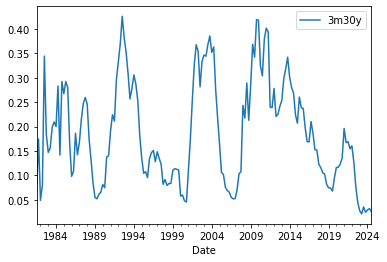

In [15]:
freq = 'Q'

fd= df.copy()
s1 = fd[fd.columns[4]]
s2 = fd[fd.columns[0]]
X = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).last()

X.loc[X>0] = 1
X.loc[X<0] = 0
X.loc['2019-01-01':].head()

y = fd[rec1].loc[X.index[0]:].resample(freq).last().fillna(method='ffill')

r1 = -24
r2 = 100
def createList(r1, r2):
    return list(range(r1, r2+1))
obs = createList(r1, r2)

corr = pd.DataFrame(columns=['Correlation'])
X11 = pd.DataFrame()
for i in obs:
    try:
        X11 = y.shift(i).corr(X)
    except:
        pass
    corr = corr.append({'Correlation': X11}, ignore_index=True)
#corr = abs(corr)

corr.index=range(r1,r2+1)
#lag = corr.index.max()
#lag = 0

X = X.shift(lag).dropna()
X = sm.add_constant(X)

y = y.loc[X.dropna().index[0]:]

prob_a = sm.Probit(y,X).fit()
prob_a.summary()

pred = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).last()
mu = 0
sigma = 1

dx = prob_a.params['const']+prob_a.params[0]*pred
dx = dx.loc[X.dropna().index[0]:]

#X['rec'] = df['USRECD']

X['model'] = norm.cdf(dx,loc=mu,scale=sigma)
#X[['rec','model']].plot()

dxa = dx.shift(lag,freq='infer')
dxb = norm.cdf(dxa,loc=mu,scale=sigma)
dxc = pd.date_range(dxa.index[0],dxa.index[-1],freq=freq)
dxd = pd.DataFrame()
dxd['Date'] = dxc
dxd['3m30y'] = dxb
y_a = dxd.set_index('Date')
y_a.loc[:].plot()

##### 2y30y

Optimization terminated successfully.
         Current function value: 0.323044
         Iterations 6


<AxesSubplot:xlabel='Date'>

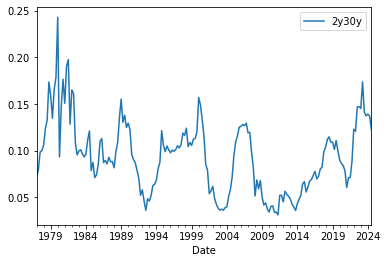

In [16]:
freq = 'Q'

fd = df.copy()
s1 = fd[fd.columns[4]]
s2 = fd[fd.columns[1]]
X = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).last()

X.loc[X>0] = 1
X.loc[X<0] = 0

y = fd[rec1].loc[X.index[0]:].resample(freq).last().fillna(method='ffill')

r1 = -24
r2 = 100
def createList(r1, r2):
    return list(range(r1, r2+1))
obs = createList(r1, r2)

corr = pd.DataFrame(columns=['Correlation'])
X11 = pd.DataFrame()
for i in obs:
    try:
        X11 = y.shift(i).corr(X)
    except:
        pass
    corr = corr.append({'Correlation': X11}, ignore_index=True)
#corr = abs(corr)

corr.index=range(r1,r2+1)
#lag = corr.index.max()
#lag = 0

X = X.shift(lag).dropna()
X = sm.add_constant(X)

y = y.loc[X.dropna().index[0]:]

prob_b = sm.Probit(y,X).fit()
prob_b.summary()

pred = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).last()
mu = 0
sigma = 1

dx = prob_b.params['const']+prob_b.params[0]*pred
dx = dx.loc[X.dropna().index[0]:]

#X['rec'] = df['USRECD']

X['model'] = norm.cdf(dx,loc=mu,scale=sigma)
#X[['rec','model']].plot()

dxa = dx.shift(lag,freq='infer')
dxb = norm.cdf(dxa,loc=mu,scale=sigma)
dxc = pd.date_range(dxa.index[0],dxa.index[-1],freq=freq)
dxd = pd.DataFrame()
dxd['Date'] = dxc
dxd['2y30y'] = dxb
y_b = dxd.set_index('Date')
y_b.loc[:].plot()

##### 3m10y

In [17]:
X

,const,0,model
1977-03-31,1.0,1.0,0.071611
1977-06-30,1.0,1.0,0.079045
1977-09-30,1.0,1.0,0.098209
1977-12-31,1.0,1.0,0.099838
1978-03-31,1.0,1.0,0.105868
...,...,...,...
2023-09-30,1.0,0.0,0.141217
2023-12-31,1.0,0.0,0.137072
2024-03-31,1.0,0.0,0.139134
2024-06-30,1.0,0.0,0.137072


In [18]:
y

1977-03-31    0.0
1977-06-30    0.0
1977-09-30    0.0
1977-12-31    0.0
1978-03-31    0.0
             ... 
2023-09-30    0.0
2023-12-31    0.0
2024-03-31    0.0
2024-06-30    0.0
2024-09-30    0.0
Freq: Q-DEC, Name: USREC, Length: 191, dtype: float64

Optimization terminated successfully.
         Current function value: 0.375297
         Iterations 5


<AxesSubplot:xlabel='Date'>

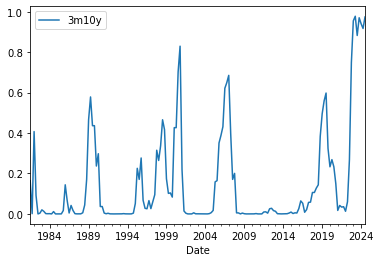

In [19]:
freq = 'Q'

fd = df.copy()
s1 = fd[fd.columns[3]]
s2 = fd[fd.columns[0]]
X = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).last()

X.loc[X>0] = 1
X.loc[X<0] = 0

y = fd[rec1].loc[X.index[0]:].resample(freq).last().fillna(method='ffill')

r1 = -24
r2 = 100
def createList(r1, r2):
    return list(range(r1, r2+1))
obs = createList(r1, r2)

corr = pd.DataFrame(columns=['Correlation'])
X11 = pd.DataFrame()
for i in obs:
    try:
        X11 = y.shift(i).corr(X)
    except:
        pass
    corr = corr.append({'Correlation': X11}, ignore_index=True)
#corr = abs(corr)

corr.index=range(r1,r2+1)
#lag = corr.index.max()
#lag = 0

X = X.shift(lag).dropna()
#X = sm.add_constant(X)

y = y.loc[X.dropna().index[0]:]

prob_c = sm.Probit(y,X).fit()

prob_c.summary()

pred = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).last()
mu = 0
sigma = 1

#dx = prob_c.params['const']+prob_c.params[0]*pred
dx = prob_c.params[0]*pred
dx = dx.loc[X.dropna().index[0]:]

#X['rec'] = df['USRECD']

X['model'] = norm.cdf(dx,loc=mu,scale=sigma)
#X[['rec','model']].plot()

dxa = dx.shift(lag,freq='infer')
dxb = norm.cdf(dxa,loc=mu,scale=sigma)
dxc = pd.date_range(dxa.index[0],dxa.index[-1],freq=freq)
dxd = pd.DataFrame()
dxd['Date'] = dxc
dxd['3m10y'] = dxb
y_c = dxd.set_index('Date')
y_c.loc[:].plot()


##### 2y10y

Optimization terminated successfully.
         Current function value: 0.320082
         Iterations 6


<AxesSubplot:xlabel='Date'>

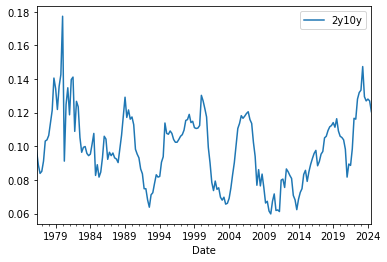

In [20]:
freq = 'Q'

fd = df.copy()
s1 = fd[fd.columns[3]]
s2 = fd[fd.columns[1]]
X = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).last()

X.loc[X>0] = 1
X.loc[X<0] = 0
X.loc['2019-01-01':].head()

y = fd[rec1].loc[X.index[0]:].resample(freq).last().fillna(method='ffill')

r1 = -24
r2 = 100
def createList(r1, r2):
    return list(range(r1, r2+1))
obs = createList(r1, r2)

corr = pd.DataFrame(columns=['Correlation'])
X11 = pd.DataFrame()
for i in obs:
    try:
        X11 = y.shift(i).corr(X)
    except:
        pass
    corr = corr.append({'Correlation': X11}, ignore_index=True)
#corr = abs(corr)

corr.index=range(r1,r2+1)
#lag = corr.index.max()
#lag = 0

X = X.shift(lag).dropna()
X = sm.add_constant(X)

y = y.loc[X.dropna().index[0]:]

prob_d = sm.Probit(y,X).fit()
prob_d.summary()

pred = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).last()
mu = 0
sigma = 1

dx = prob_d.params['const']+prob_d.params[0]*pred
dx = dx.loc[X.dropna().index[0]:]

#X['rec'] = df['USRECD']

X['model'] = norm.cdf(dx,loc=mu,scale=sigma)
#X[['rec','model']].plot()

dxa = dx.shift(lag,freq='infer')
dxb = norm.cdf(dxa,loc=mu,scale=sigma)
dxc = pd.date_range(dxa.index[0],dxa.index[-1],freq=freq)
dxd = pd.DataFrame()
dxd['Date'] = dxc
dxd['2y10y'] = dxb
y_d = dxd.set_index('Date')
y_d.loc[:].plot()

##### 3m5y

Optimization terminated successfully.
         Current function value: 0.296418
         Iterations 6


<AxesSubplot:xlabel='Date'>

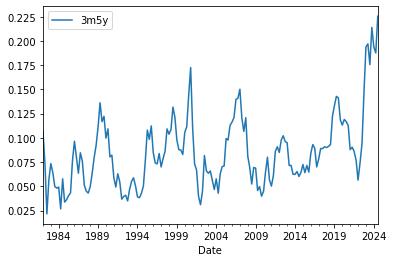

In [21]:
freq = 'Q'

fd= df.copy()
s1 = fd[fd.columns[2]]
s2 = fd[fd.columns[0]]
X = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).last()

X.loc[X>0] = 1
X.loc[X<0] = 0
X.loc['2019-01-01':].head()

y = fd[rec1].loc[X.index[0]:].resample(freq).last().fillna(method='ffill').fillna(method='bfill')

r1 = -24
r2 = 100
def createList(r1, r2):
    return list(range(r1, r2+1))
obs = createList(r1, r2)

corr = pd.DataFrame(columns=['Correlation'])
X11 = pd.DataFrame()
for i in obs:
    try:
        X11 = y.shift(i).corr(X)
    except:
        pass
    corr = corr.append({'Correlation': X11}, ignore_index=True)
#corr = abs(corr)

corr.index=range(r1,r2+1)
#lag = corr.index.max()
#lag = 0

X = X.shift(2).dropna()
X = sm.add_constant(X)

y = y.loc[X.dropna().index[0]:]

prob_e = sm.Probit(y,X).fit()
prob_e.summary()

pred = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).last()
mu = 0
sigma = 1

dx = prob_e.params['const']+prob_e.params[0]*pred
dx = dx.loc[X.dropna().index[0]:]

#X['rec'] = df['USRECD']

X['model'] = norm.cdf(dx,loc=mu,scale=sigma)
#X[['rec','model']].plot()

dxa = dx.shift(lag,freq='infer')
dxb = norm.cdf(dxa,loc=mu,scale=sigma)
dxc = pd.date_range(dxa.index[0],dxa.index[-1],freq=freq)
dxd = pd.DataFrame()
dxd['Date'] = dxc
dxd['3m5y'] = dxb
y_e = dxd.set_index('Date')
y_e.loc[:].plot()

##### 2y5y

Optimization terminated successfully.
         Current function value: 0.320517
         Iterations 6


<AxesSubplot:xlabel='Date'>

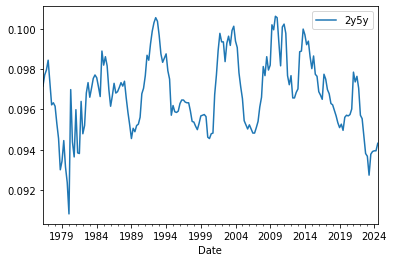

In [22]:
freq = 'Q'

fd = df.copy()
s1 = fd[fd.columns[2]]
s2 = fd[fd.columns[1]]
X = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).last()

X.loc[X>0] = 1
X.loc[X<0] = 0
X.loc['2019-01-01':].head()

y = fd[rec1].loc[X.index[0]:].resample(freq).last().fillna(method='ffill').fillna(method='bfill')

r1 = -24
r2 = 100
def createList(r1, r2):
    return list(range(r1, r2+1))
obs = createList(r1, r2)

corr = pd.DataFrame(columns=['Correlation'])
X11 = pd.DataFrame()
for i in obs:
    try:
        X11 = y.shift(i).corr(X)
    except:
        pass
    corr = corr.append({'Correlation': X11}, ignore_index=True)
#corr = abs(corr)

corr.index=range(r1,r2+1)
#lag = corr.index.max()
#lag = 0

X = X.shift(lag).dropna()
X = sm.add_constant(X)

y = y.loc[X.dropna().index[0]:]

prob_f = sm.Probit(y,X).fit()
prob_f.summary()

pred = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).last()
mu = 0
sigma = 1

dx = prob_f.params['const']+prob_f.params[0]*pred
dx = dx.loc[X.dropna().index[0]:]

#X['rec'] = df['USRECD']

X['model'] = norm.cdf(dx,loc=mu,scale=sigma)
#X[['rec','model']].plot()

dxa = dx.shift(lag,freq='infer')
dxb = norm.cdf(dxa,loc=mu,scale=sigma)
dxc = pd.date_range(dxa.index[0],dxa.index[-1],freq=freq)
dxd = pd.DataFrame()
dxd['Date'] = dxc
dxd['2y5y'] = dxb
y_f = dxd.set_index('Date')
y_f.loc[:].plot()

##### 3m3x18

Optimization terminated successfully.
         Current function value: 0.320411
         Iterations 6


<AxesSubplot:xlabel='Date'>

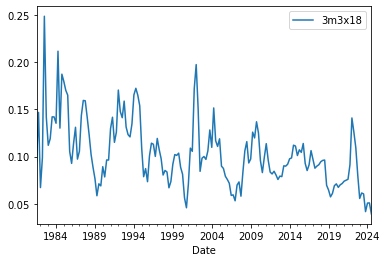

In [23]:
freq = 'Q'

fd = df.copy()
s1 = fd[fd.columns[-1]]
s2 = fd[fd.columns[0]]
X = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).last()

X.loc[X>0] = 1
X.loc[X<0] = 0
X.loc['2019-01-01':].head()

y = fd[rec1].loc[X.index[0]:].resample(freq).last().fillna(method='ffill').fillna(method='bfill')

r1 = -24
r2 = 100
def createList(r1, r2):
    return list(range(r1, r2+1))
obs = createList(r1, r2)

corr = pd.DataFrame(columns=['Correlation'])
X11 = pd.DataFrame()
for i in obs:
    try:
        X11 = y.shift(i).corr(X)
    except:
        pass
    corr = corr.append({'Correlation': X11}, ignore_index=True)
#corr = abs(corr)

corr.index=range(r1,r2+1)
#lag = corr.index.max()
#lag = 0

X = X.shift(lag).dropna()
X = sm.add_constant(X)

y = y.loc[X.dropna().index[0]:]

prob_g = sm.Probit(y,X).fit()
prob_g.summary()

pred = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).last()
mu = 0
sigma = 1

dx = prob_g.params['const']+prob_g.params[0]*pred
dx = dx.loc[X.dropna().index[0]:]

#X['rec'] = df['USRECD']

X['model'] = norm.cdf(dx,loc=mu,scale=sigma)
#X[['rec','model']].plot()

dxa = dx.shift(lag,freq='infer')
dxb = norm.cdf(dxa,loc=mu,scale=sigma)
dxc = pd.date_range(dxa.index[0],dxa.index[-1],freq=freq)
dxd = pd.DataFrame()
dxd['Date'] = dxc
dxd['3m3x18'] = dxb
y_g = dxd.set_index('Date')
y_g.loc[:].plot()

###### Add all probabilities into one frame

In [24]:
y_g['3m30y'] = y_a['3m30y']
y_g['2y30y'] = y_b
y_g['3m10y'] = y_c
y_g['2y10y'] = y_d
y_g['3m5y'] = y_e
y_g['2y5y'] = y_f

In [25]:
y_g

,3m3x18,3m30y,2y30y,3m10y,2y10y,3m5y,2y5y
Date,,,,,,,
1981-09-30,0.094711,0.063872,0.197544,1.644769e-01,0.141114,NaN,0.093817
1981-12-31,0.146774,0.174461,0.128247,1.284172e-03,0.108836,NaN,0.096400
1982-03-31,0.067258,0.048760,0.165061,4.071867e-01,0.126679,0.107117,0.094797
1982-06-30,0.098957,0.080604,0.160915,9.100629e-02,0.123438,0.074096,0.095204
1982-09-30,0.248541,0.344242,0.108282,9.798114e-07,0.105208,0.021516,0.096812
...,...,...,...,...,...,...,...
2023-09-30,0.060551,0.035241,0.141217,8.822474e-01,0.129425,0.175498,0.093784
2023-12-31,0.041810,0.024276,0.137072,9.698302e-01,0.126952,0.213924,0.093918
2024-03-31,0.050846,0.028842,0.139134,9.402665e-01,0.128047,0.193817,0.093952


<AxesSubplot:xlabel='Date'>

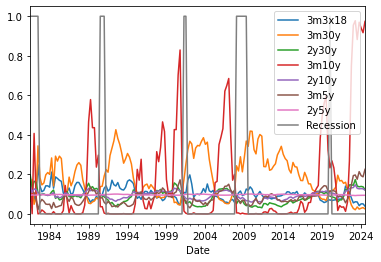

In [26]:
y_g['Recession'] = y.resample('Q').last()
y_g.plot()

In [27]:
y_g[y_g.columns[[0,1,2,3,4,6]]]

,3m3x18,3m30y,2y30y,3m10y,2y10y,2y5y
Date,,,,,,
1981-09-30,0.094711,0.063872,0.197544,1.644769e-01,0.141114,0.093817
1981-12-31,0.146774,0.174461,0.128247,1.284172e-03,0.108836,0.096400
1982-03-31,0.067258,0.048760,0.165061,4.071867e-01,0.126679,0.094797
1982-06-30,0.098957,0.080604,0.160915,9.100629e-02,0.123438,0.095204
1982-09-30,0.248541,0.344242,0.108282,9.798114e-07,0.105208,0.096812
...,...,...,...,...,...,...
2023-09-30,0.060551,0.035241,0.141217,8.822474e-01,0.129425,0.093784
2023-12-31,0.041810,0.024276,0.137072,9.698302e-01,0.126952,0.093918
2024-03-31,0.050846,0.028842,0.139134,9.402665e-01,0.128047,0.093952


In [28]:
z_a = y_a.iloc[-1]*prob_a.prsquared
z_b = y_b.iloc[-1]*prob_b.prsquared
z_c = y_c.iloc[-1]*prob_c.prsquared
z_d = y_d.iloc[-1]*prob_d.prsquared
z_e = y_e.iloc[-1]*prob_e.prsquared
z_f = y_f.iloc[-1]*prob_f.prsquared

In [29]:
z_a[0]+z_b[0]+z_c[0]+z_d[0]+z_e[0]+z_f[0]

-0.1626043736147742

# Probability and Pseudo R2

In [30]:
recs = pd.DataFrame(y_g.iloc[-1][:-1])
recs.columns = ['Probability']

rsqrd = pd.DataFrame([prob_g.prsquared,prob_a.prsquared,prob_b.prsquared,prob_c.prsquared,prob_d.prsquared,prob_e.prsquared,prob_f.prsquared])
rsqrd.columns = ['Pseudo R2']
rsqrd['Spread'] = pd.DataFrame(y_g.columns[:7])
rsqrd = rsqrd.set_index('Spread')

ctt = pd.concat([recs,rsqrd],axis=1)
ctt

,Probability,Pseudo R2
Spread,,
3m3x18,0.039368,0.002631
3m30y,0.025666,0.003381
2y30y,0.122461,0.002737
3m10y,0.973816,-0.168218
2y10y,0.120518,0.001395
3m5y,0.225447,0.002730
2y5y,0.094323,0.000036


# SPX

In [31]:
bt = pd.read_excel('C:/Users/lavella/Quintet Private Bank/UK Sandbox DPT ICS - Documents/Sector Selection - Copy/Philip Odum/Philip Odum/Inflation/Data/SPX.xlsx').set_index('Name').iloc[:,-1].resample('D').last().fillna(method='ffill')
bt.columns = ['SPX']
btx = bt
df['SPX'] = btx
df['SPX']

1950-01-01   NaN
1950-01-02   NaN
1950-01-03   NaN
1950-01-04   NaN
1950-01-05   NaN
              ..
2024-08-01   NaN
2024-08-02   NaN
2024-08-03   NaN
2024-08-04   NaN
2024-08-05   NaN
Freq: D, Name: SPX, Length: 27246, dtype: float64

In [32]:
freq = 'Q'

ols = df
s1 = ols['SPX']
s1 = s1.fillna(method='ffill').dropna().resample(freq).last().pct_change()
X = s1*1

X.loc[X>-0.25] = 0
X.loc[X<-0.25] = 1
X.loc['2019-01-01':].head()
y = ols[rec1].loc[X.index[0]:X.index[-1]].resample(freq).last().fillna(method='ffill').fillna(method='bfill')

r1 = -24
r2 = 100
def createList(r1, r2):
    return list(range(r1, r2+1))
obs = createList(r1, r2)

corr = pd.DataFrame(columns=['Correlation'])
X11 = pd.DataFrame()
for i in obs:
    try:
        X11 = y.shift(i).corr(X)
    except:
        pass
    corr = corr.append({'Correlation': X11}, ignore_index=True)
#corr = abs(corr)

corr.index=range(r1,r2+1)
#lag = corr.index.max()
#lag = 0

X = X.shift(lag).dropna()
X = sm.add_constant(X)

y = y.loc[X.dropna().index[0]:]

prob_spx = sm.Probit(y,X).fit()
prob_spx.summary()

pred = s1
mu = 0
sigma = 1

dx = prob_spx.params['const']+prob_spx.params[0]*pred
dx = dx.loc[X.dropna().index[0]:]

#X['rec'] = df['USRECD']

X['model'] = norm.cdf(dx,loc=mu,scale=sigma)
#X[['rec','model']].plot()

dxa = dx.shift(lag,freq='infer')
dxb = norm.cdf(dxa,loc=mu,scale=sigma)
dxc = pd.date_range(dxa.index[0],dxa.index[-1],freq=freq)
dxd = pd.DataFrame()
dxd['Date'] = dxc
dxd['SPX'] = dxb
y_spx = dxd.set_index('Date')
y_spx.loc[:].tail()

         Current function value: 0.348346
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,SPX
Date,
2023-09-30,0.11157
2023-12-31,0.11157
2024-03-31,0.11157
2024-06-30,0.11157
2024-09-30,0.11157


### Get statistics from the Probit Model

In [33]:
prob_a.prsquared

0.0033808088396989344

In [34]:
y_a.iloc[-1]*prob_a.prsquared+y_b.iloc[-1]*prob_b.prsquared+y_c.iloc[-1]*prob_c.prsquared+y_d.iloc[-1]*prob_d.prsquared+y_e.iloc[-1]*prob_e.prsquared+y_f.iloc[-1]*prob_f.prsquared

2y10y   NaN
2y30y   NaN
2y5y    NaN
3m10y   NaN
3m30y   NaN
3m5y    NaN
Name: 2024-09-30 00:00:00, dtype: float64

### Recession Probability - ICI

In [35]:
lags = 4


df1 = df1.fillna(0)
test = df1[df1.columns[0]].copy()
test.loc[test!=0]=1

test = test.resample('Q').last().fillna(method='ffill')
X = test

X.loc[X>0] = 1
X.loc[X<0] = 0
#X.loc['2019-01-01':].head()

y = ols['USRECD'].loc[X.index[0]:X.index[-1]].resample(freq).last().fillna(method='ffill')

r1 = -24
r2 = 24
def createList(r1, r2):
    return list(range(r1, r2+1))
obs = createList(r1, r2)

corr = pd.DataFrame(columns=['Correlation'])
X11 = pd.DataFrame()
for i in obs:
    try:
        X11 = y.shift(i).corr(X)
    except:
        pass
    corr = corr.append({'Correlation': X11}, ignore_index=True)
#corr = abs(corr)

corr.index=range(r1,r2+1)
#lag = corr.index.max()
lag = 0

X = X.shift(lags).dropna()
X = sm.add_constant(X)

y = y.loc[X.dropna().index[0]:]

prob = sm.Probit(y,X).fit()

#pred = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).min()
pred = df1['average'].resample('Q').last().fillna(method='ffill').loc[X.index[0]:X.index[-1]]

mu = 0
sigma = 1

dx = prob.params['const']+prob.params[0]*pred
dx = dx.loc[X.dropna().index[0]:]

X['rec'] = df['USRECD']

X['model'] = norm.cdf(dx,loc=mu,scale=sigma)
#X[['rec','model']].plot()
ici = X['model']
ici.tail()

Optimization terminated successfully.
         Current function value: 0.378237
         Iterations 5


Date
2023-06-30    0.039888
2023-09-30    0.054137
2023-12-31    0.068155
2024-03-31    0.048791
2024-06-30    0.074114
Freq: Q-DEC, Name: model, dtype: float64

<AxesSubplot:xlabel='Date'>

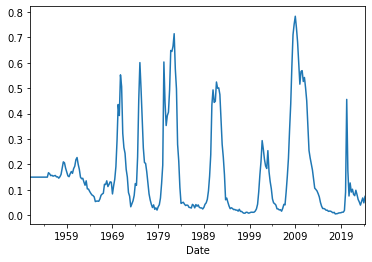

In [36]:
ici.plot()

In [37]:
prob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                 USRECD   No. Observations:                  294
Model:                         Probit   Df Residuals:                      292
Method:                           MLE   Df Model:                            1
Date:                Wed, 07 Aug 2024   Pseudo R-squ.:               0.0004876
Time:                        00:22:43   Log-Likelihood:                -111.20
converged:                       True   LL-Null:                       -111.26
Covariance Type:            nonrobust   LLR p-value:                    0.7419
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0364      0.342     -3.027      0.002      -1.708      -0.365
average       -0.1184      0.356     -0.332      0.740      -0.816       0.579
==============================================================================
"""

X = ja.resample('D').last().fillna(method='ffill').dropna().iloc[:-2]
#X = X.shift(lag).dropna()
X = sm.add_constant(X)

y = ols['USRECD'].loc[X.index[0]:X.index[-1]].resample(freq).max().fillna(method='ffill')
y = y.loc[X.dropna().index[0]:]

prob = sm.Probit(y,X).fit()

#pred = s1.sub(s2).fillna(method='ffill').dropna().resample(freq).min()
pred = df2.resample('D').last().fillna(method='ffill').loc[X.index[0]:X.index[-1]]

mu = 0
sigma = 1

dx = prob.params['const']+prob.params[0]*pred
dx = dx.loc[X.dropna().index[0]:]

X['rec'] = df['USRECD']

X['model'] = norm.cdf(dx,loc=mu,scale=sigma)
#X[['rec','model']].plot()
cb = X['model']
cb.plot()

<AxesSubplot:>

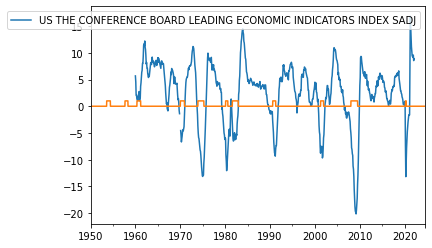

In [38]:
df2.plot()
ols['USRECD'].plot()

In [39]:
y_g

,3m3x18,3m30y,2y30y,3m10y,2y10y,3m5y,2y5y,Recession
Date,,,,,,,,
1981-09-30,0.094711,0.063872,0.197544,1.644769e-01,0.141114,NaN,0.093817,1.0
1981-12-31,0.146774,0.174461,0.128247,1.284172e-03,0.108836,NaN,0.096400,1.0
1982-03-31,0.067258,0.048760,0.165061,4.071867e-01,0.126679,0.107117,0.094797,1.0
1982-06-30,0.098957,0.080604,0.160915,9.100629e-02,0.123438,0.074096,0.095204,1.0
1982-09-30,0.248541,0.344242,0.108282,9.798114e-07,0.105208,0.021516,0.096812,1.0
...,...,...,...,...,...,...,...,...
2023-09-30,0.060551,0.035241,0.141217,8.822474e-01,0.129425,0.175498,0.093784,0.0
2023-12-31,0.041810,0.024276,0.137072,9.698302e-01,0.126952,0.213924,0.093918,0.0
2024-03-31,0.050846,0.028842,0.139134,9.402665e-01,0.128047,0.193817,0.093952,0.0


In [40]:
df['3m3x18'] = df['3X18'].sub(df['DGS3MO'])

book = load_workbook('C:/Users/lavella/Quintet Private Bank/UK Sandbox DPT ICS - Documents/Sector Selection - Copy/Philip Odum/Philip Odum/Inflation/Data/Fixed Income - Recession Probabiliy (new).xlsx')
writer = pd.ExcelWriter('C:/Users/lavella/Quintet Private Bank/UK Sandbox DPT ICS - Documents/Sector Selection - Copy/Philip Odum/Philip Odum/Inflation/Data/Fixed Income - Recession Probabiliy (new).xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

ctt.to_excel(writer, "Stats - No lag")
#y.to_excel(writer, "Test")

writer.save()

In [41]:
ctt

,Probability,Pseudo R2
Spread,,
3m3x18,0.039368,0.002631
3m30y,0.025666,0.003381
2y30y,0.122461,0.002737
3m10y,0.973816,-0.168218
2y10y,0.120518,0.001395
3m5y,0.225447,0.002730
2y5y,0.094323,0.000036


#Find Python API for NY-Fed in order to obtain following; https://www.newyorkfed.org/research/capital_markets/ycfaq.html#/Q11

In [42]:
df['US10Y3M'] = df[df.columns[0]].sub(df[df.columns[1]])

mu = df[df.columns[3]].last()
sigma = df[df.columns[3]].std()

#Recession probability
scipy.stats.norm(mu,sigma).pdf(0)

TypeError: last() missing 1 required positional argument: 'offset'

In [ ]:
df['BAMLC0A4CBBB'].dropna().plot()

In [ ]:
series1